In [2]:
import warnings

import aesara.tensor as at
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import scipy as sp
import seaborn as sns

from scipy import stats
from scipy.special import expit as logistic
from scipy.special import softmax

%config InlineBackend.figure_format = 'retina'
warnings.simplefilter(action="ignore", category=FutureWarning)
RANDOM_SEED = 8927
np.random.seed(286)

In [3]:
az.style.use("arviz-darkgrid")
az.rcParams["stats.hdi_prob"] = 0.89


def standardize(series):
    """Standardize a pandas series"""
    return (series - series.mean()) / series.std()

## Exercise 11E1-2-3

* If an event has probability 0.35, what are the log-odds of this event?
* If an event has log-odds 3.2, what is the probability of this event?
* Suppose that a coefficient in a logistic regression has value 1.7. What does this imply about the proportional change in odds of the outcome?



We define the logit and inverse logit functions simply as

In [4]:
def prob2logodds(p): return np.log(p/(1-p))
def logodds2prob(l): return np.exp(l)/(1+np.exp(l))

And use them for calculations.
Here we have negative log-odds because we have less than 50% chances

In [5]:
prob2logodds(.35)

-0.6190392084062235

while here our logodds are positive, therefore returning a probability above 0.5

In [6]:
logodds2prob(3.2)

0.9608342772032357

Remember that when logodds get higher and higher, the probability is asymptotically 1, so the largest changes in probability are with the logodds between -3 and 3

[0.5        0.73105858 0.88079708 0.95257413 0.98201379 0.99330715
 0.99752738 0.99908895 0.99966465 0.99987661]


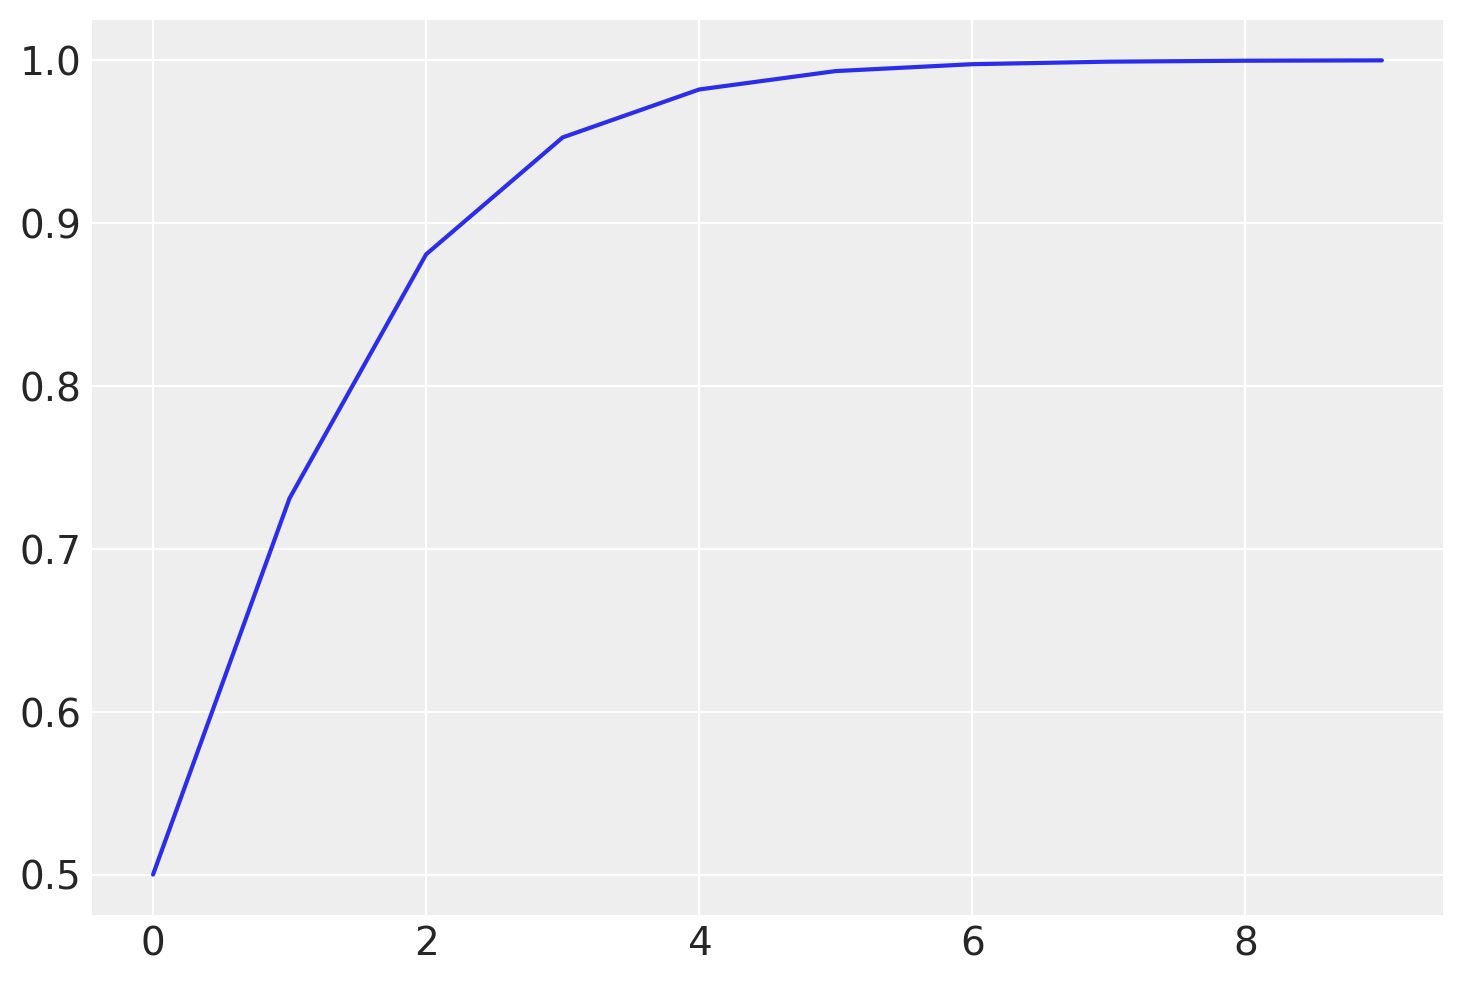

In [10]:
print( logodds2prob( range(10) ) )
fig = sns.lineplot( logodds2prob( range(10) ) )

A logistic regression is such that, for example,
\begin{align}
logistic(p_i) &= \alpha + \beta x_i
\end{align}

meaning that, if $\beta$ has value $1.7$, a change of $1$ in $x_i$ triggers a proportional change of $invlogit( 1.7 )$ in $p_i$. This change, in our case, is

In [19]:
logodds2prob(1.7)

0.8455347349164652

## Exercise 11E4

Why do Poisson regressions sometimes require the use of an offset? Provide an example.

Data used for a Poisson regression where observations are collected at different times will correspond to calculating the lambda parameter differently. Since $\lambda = \mu/\tau$, where the numerator is the observed counts, and the denominator the time (exposure), we can rewrite the regression of $\lambda$ as

\begin{align}
log( \lambda_i ) &= \alpha + \beta x_i \\ 
log( \mu_i / \tau_i) &=  \alpha + \beta x_i \\
log( \mu_i)   &= log(\tau_i) +  \alpha + \beta x_i \\
\end{align}

making the regression

\begin{align}
y_i &\sim Poisson(\mu_i) \\ 
log( \mu_i)   &= log(\tau_i) +  \alpha + \beta x_i \\
\end{align}

Consider the deaths of horsekick in the prussian army across 20 years ([publication](https://eudml.org/doc/204250)). The estimated poisson parameter for the deaths each year is 0.61. Now imagine the french army does the same measurement every month, and the death rate monthly is 0.091. Simulate the data.

In [18]:
prussian_kick = np.random.poisson(.61, 20)

In [19]:
french_kick = np.random.poisson(.091, 20*12)

The exposure for the french data is 1 (month) and for the prussian data is 12 (months). Define a dataframe with these information, and also make the logarithm of the exposure

In [37]:
d = pd.DataFrame()
d['deaths'] = np.concatenate( (prussian_kick, french_kick) )
d['country'] = np.concatenate( ( np.repeat(0, 20), np.repeat(1, 20*12) ) ).astype("float")
d['exposure'] = np.concatenate( ( np.ones(20)*12, np.ones(20*12) ) )
d['log_exposure'] = np.log(d['exposure']).astype("float")

In [38]:
d

,deaths,country,exposure,log_exposure
0,0,0.0,12.0,2.484907
1,1,0.0,12.0,2.484907
2,1,0.0,12.0,2.484907
3,0,0.0,12.0,2.484907
4,0,0.0,12.0,2.484907
...,...,...,...,...
255,0,1.0,1.0,0.000000
256,0,1.0,1.0,0.000000
257,0,1.0,1.0,0.000000
258,0,1.0,1.0,0.000000


Define a model containing the exposure

In [43]:
# fit the model:
with pm.Model() as m11e4:
    a = pm.Normal("a", 0.0, 1.0)
    b = pm.Normal("b", 0.0, 1.0)

    lam = pm.math.exp( a + b * d.country + d.log_exposure )

    obs = pm.Poisson("y", lam, observed=d.deaths)

    trace_11e4 = pm.sample(1000, tune=2000, random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 3 seconds.


and show statistics for the lambdas of the prussian army and of the french army. Note that here we take as reference exposure the monthly one, so the known poisson rate for the prussian army is

In [46]:
0.61/12

0.050833333333333335

By comparison, we can see the french army has around double the rate of killing by horse kicks.

In [45]:
lambda_old = np.exp(trace_11e4["posterior"]["a"])
lambda_new = np.exp(trace_11e4["posterior"]["a"]+trace_11e4["posterior"]["b"])

#az.summary({"lambda_old": lambda_old}, kind="stats", round_to=2)
az.summary({"lambda_old": lambda_old, "lambda_new": lambda_new}, kind="stats", round_to=2)

,mean,sd,hdi_5.5%,hdi_94.5%
lambda_old,0.04,0.01,0.02,0.06
lambda_new,0.09,0.02,0.06,0.12


## Exercise 11M1

As explained in the chapter, binomial data can be organized in aggregated and disaggregated forms, without any impact on inference. But the likelihood of the data does change when the data are converted between the two formats. Can you explain why?

The likelihood of aggregated data takes into account the number of possible combinations of successes in the binomial coefficient $\binom{n}{k}$. For example, having 4 out of 10 successes in aggregated and disaggregated form results in the following loglikelihood for

In [47]:
from scipy.stats import binom

* the aggregated data where $\binom{n}{k}=\binom{10}{4}$

In [53]:
binom.logpmf( k=4, n=10, p=.35)

-1.4020427180880288

* the disaggregated data where $\binom{n_i}{k_i}$is either $\binom{1}{1}$ or $\binom{1}{0}$.

In [57]:
np.sum( binom.logpmf( k=[0,1,0,1,0,1,0,1,0,0] , n=np.ones(10) , p=.35) )

-6.783985994549436

## Exercise 11M2

If a coefficient in a Poisson regression has value 1.7, what does this imply about the change in the outcome?

Consider the Poisson regression

\begin{align}
y_i &\sim Poisson(\lambda_i) \\ 
log( \lambda_i)   &= \alpha + 1.7 x_i \\
\end{align}

For simplicity assume that $\alpha=0$. Then, every time $x_i$ increases by one unit, $\lambda$ (the mean and variance of the poisson) increases exponentially with base $exp(1.7)$. For example, when $x_i=3$, then $\lambda_i$ will grow to a value of $exp(1.7 \times 3) = exp(1.7)^3$. Similarly, if $\alpha \neq 0$, we can say that
$$ log( \lambda_i) -  log( exp(\alpha) ) = 1.7 x_i $$
which means
$$ log( \lambda_i / exp(\alpha) ) = 1.7 x_i .$$
In such a case, the value of $\lambda_i$ grows with a value of  $exp(\alpha) \times exp(1.7)^{x_i}$.

## Exercise 11M3-4-5

* Explain why the logit link is appropriate for a binomial generalized linear model.
* Explain why the log link is appropriate for a Poisson generalized linear model.
* What would it imply to use a logit link for the mean of a Poisson generalized linear model? Can you think of a real research problem for which this would make sense?

## Exercise 11M6

State the constraints for which the binomial and Poisson distributions have maximum en- tropy. Are the constraints different at all for binomial and Poisson? Why or why not?

## Exercise 11H3

In [3]:
d = pd.read_csv("Data/eagles.csv", sep=",")
d

,y,n,P,A,V
0,17,24,L,A,L
1,29,29,L,A,S
2,17,27,L,I,L
3,20,20,L,I,S
4,1,12,S,A,L
5,15,16,S,A,S
6,0,28,S,I,L
7,1,4,S,I,S


Make dummy variables

0=small 1=large

In [4]:
d.V.factorize()

(array([0, 1, 0, 1, 0, 1, 0, 1]), Index(['L', 'S'], dtype='object'))

In [5]:
d["Vdum"] = [ 1 if i==0 else 0 for i in d.V.factorize()[0] ]

In [6]:
d.P.factorize()

(array([0, 0, 0, 0, 1, 1, 1, 1]), Index(['L', 'S'], dtype='object'))

In [7]:
d["Pdum"] = [ 1 if i==0 else 0 for i in d.P.factorize()[0] ]

0=not adult 1=adult 

In [8]:
d.A.factorize()

(array([0, 0, 1, 1, 0, 0, 1, 1]), Index(['A', 'I'], dtype='object'))

In [9]:
d["Adum"] = [ 1 if i==0 else 0 for i in d.A.factorize()[0] ]

In [10]:
d

,y,n,P,A,V,Vdum,Pdum,Adum
0,17,24,L,A,L,1,1,1
1,29,29,L,A,S,0,1,1
2,17,27,L,I,L,1,1,0
3,20,20,L,I,S,0,1,0
4,1,12,S,A,L,1,0,1
5,15,16,S,A,S,0,0,1
6,0,28,S,I,L,1,0,0
7,1,4,S,I,S,0,0,0


### Question a

model the number of successful attempts at stealing using a binomial GLM

In [11]:
with pm.Model() as m11h3a:
    a = pm.Normal("a", 0.0, 1.5)
    Bp = pm.Normal("Bp", 0.0, .5 ,shape=2)
    Bv = pm.Normal("Bv", 0.0, .5, shape=2)
    Ba = pm.Normal("Ba", 0.0, .5, shape=2)
    
    p = pm.Deterministic( "p", pm.math.invlogit(a + Bp[d.Pdum] + Bv[d.Vdum] + Ba[d.Adum]) )
    
    stealing = pm.Binomial("stealing", d.n, p, observed=d.y)

    trace_11h3a = pm.sample(random_seed=RANDOM_SEED, cores=8)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [a, Bp, Bv, Ba]


Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 9 seconds.


In [12]:
az.summary(trace_11h3a, var_names=["a", "p", "Bp", "Bv", "Ba"], round_to=2)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,0.58,0.61,-0.38,1.57,0.01,0.01,3976.77,4256.95,1.0
p[0],0.73,0.07,0.63,0.84,0.00,0.00,10399.45,7174.38,1.0
p[1],0.96,0.02,0.93,0.98,0.00,0.00,11329.60,6028.83,1.0
p[2],0.56,0.07,0.43,0.67,0.00,0.00,10665.75,7122.00,1.0
p[3],0.92,0.03,0.87,0.97,0.00,0.00,10363.07,6408.34,1.0
p[4],0.25,0.07,0.14,0.37,0.00,0.00,10200.63,7127.83,1.0
p[5],0.75,0.08,0.63,0.87,0.00,0.00,12895.48,6469.09,1.0
p[6],0.14,0.04,0.07,0.20,0.00,0.00,10061.31,7279.99,1.0
p[7],0.58,0.10,0.42,0.74,0.00,0.00,11210.48,7056.95,1.0
Bp[0],-1.03,0.39,-1.64,-0.38,0.01,0.00,5501.00,5931.07,1.0


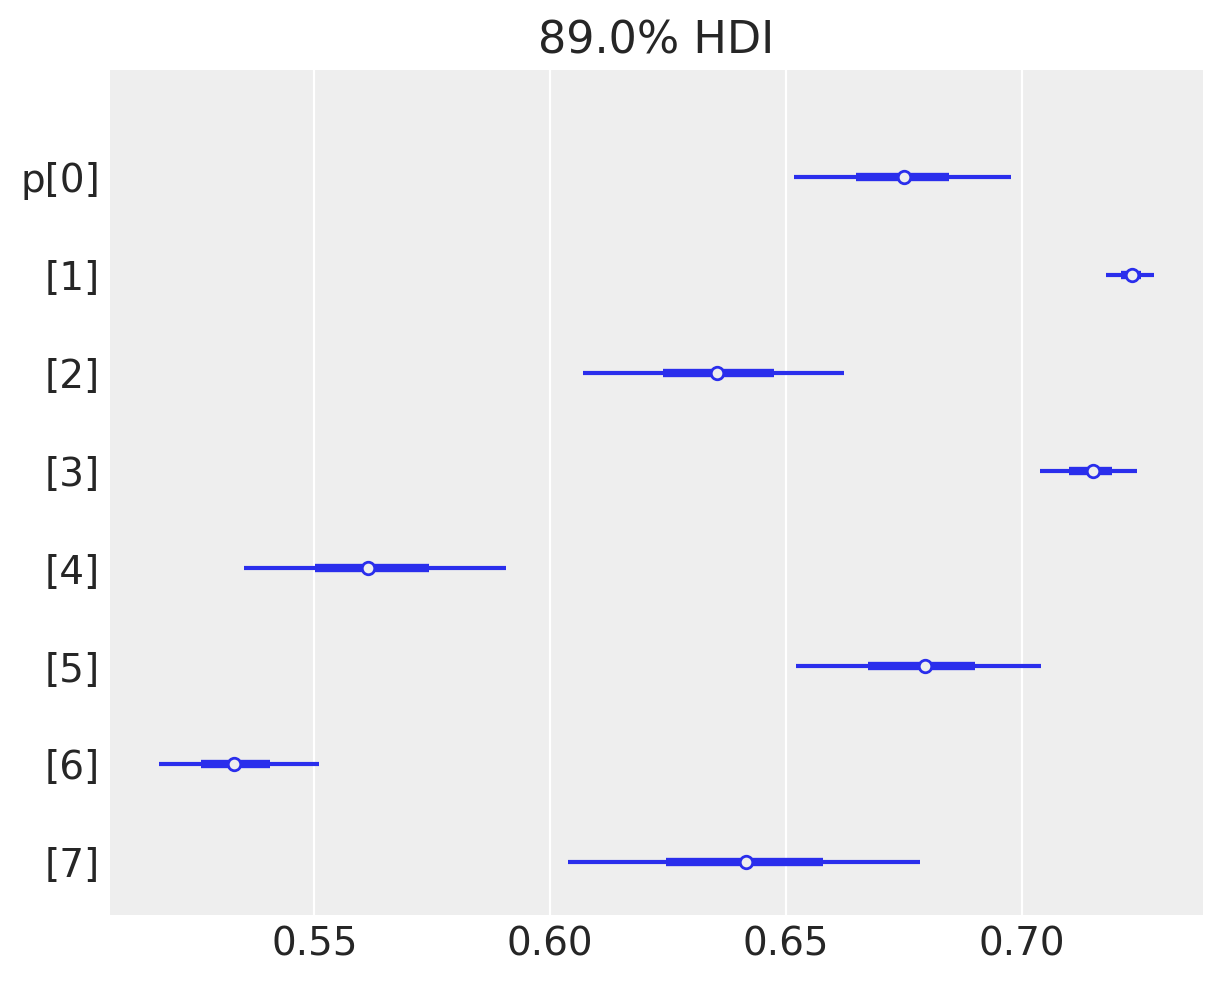

In [13]:
az.plot_forest(trace_11h3a, var_names=["p"], combined=True, transform=logistic);

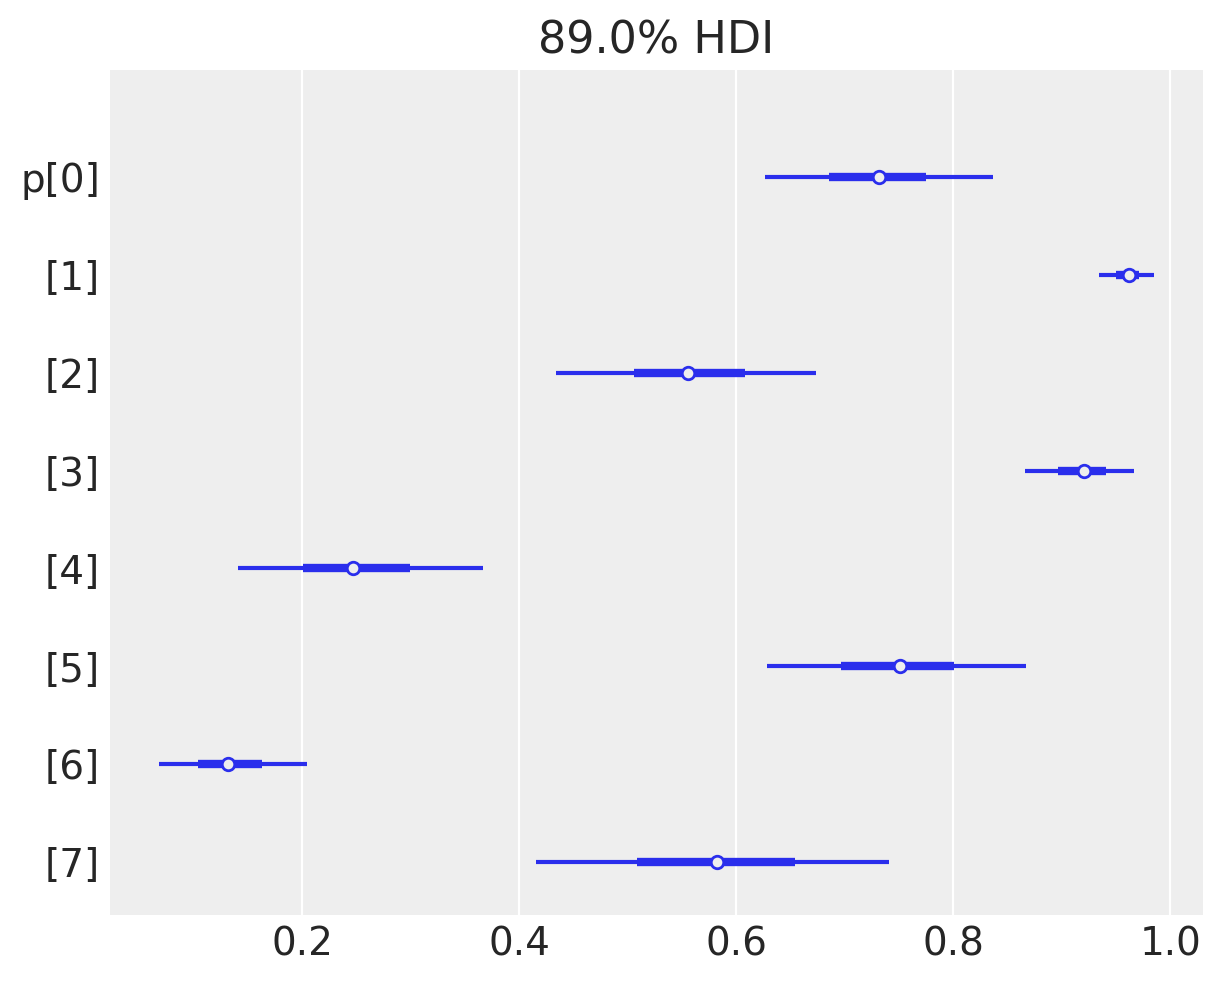

In [14]:
az.plot_forest(trace_11h3a, var_names=["p"], combined=True);

In [50]:
with m11h3a:
    pp = pm.sample_posterior_predictive(
        trace_11h3a, random_seed=RANDOM_SEED, var_names=["stealing"])

Sampling: [stealing]


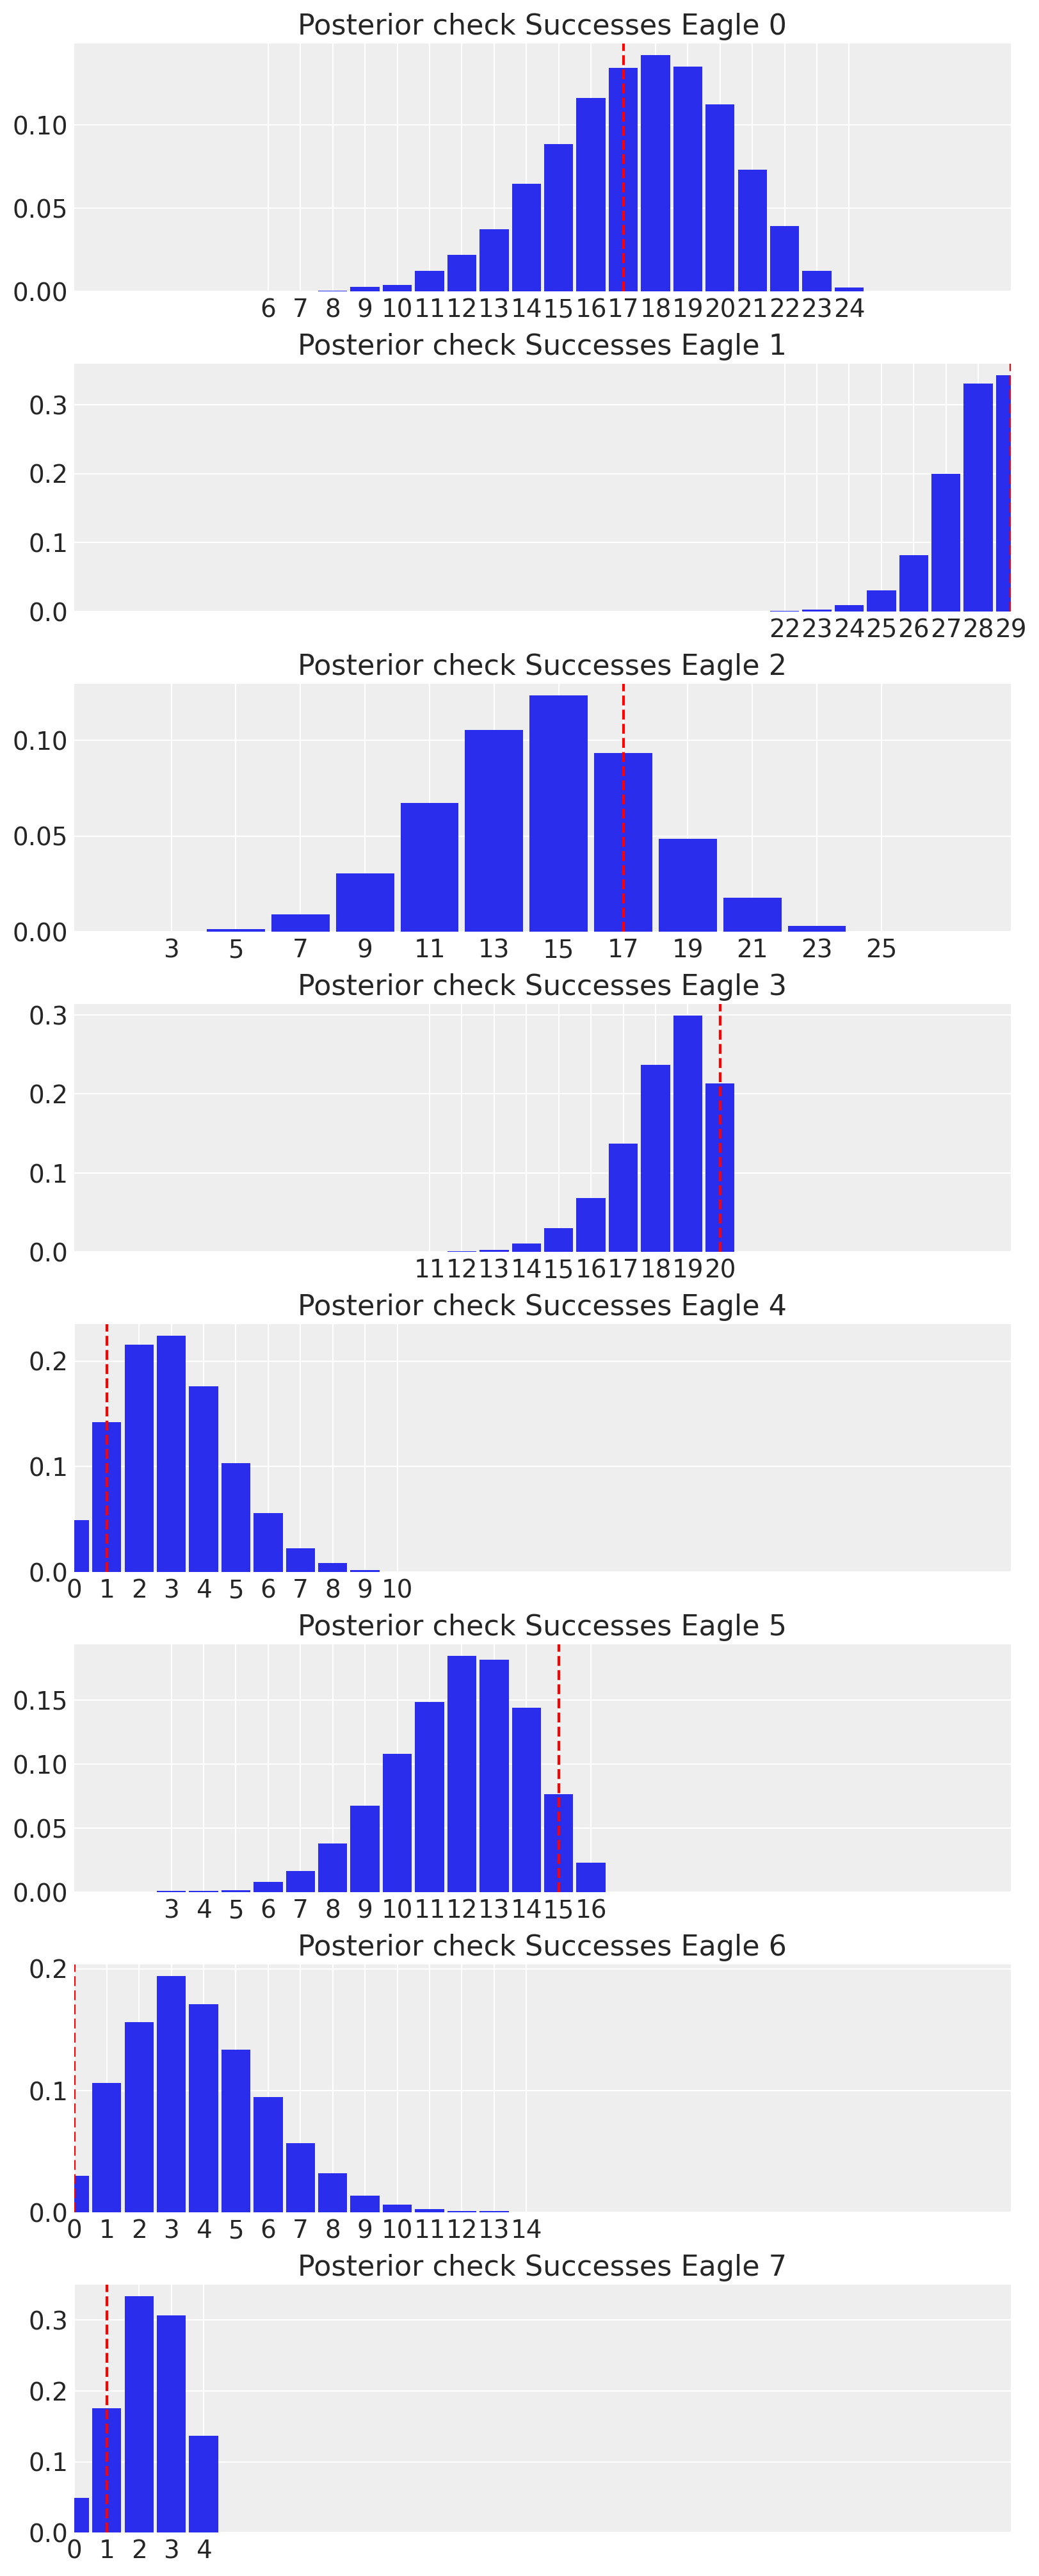

In [16]:
fig, ax = plt.subplots( 8, 1, figsize=(8,20) )
xlim=(0,np.max(np.array(pp["posterior_predictive"]["stealing"])))
for i in range(8):
    plot = az.plot_dist( np.array( pp["posterior_predictive"]["stealing"].sel(stealing_dim_2=i) ), ax=ax[i] )
    plot.axvline(x=d.y[i], c="r", ls='--', alpha=1)
    ax[i].set_xlim(xlim)
    ax[i].set_title(f"Posterior check Successes Eagle {i}", pad=5)

### Interaction model

In [36]:
d["APdum"] = d.Pdum + 2*d.Adum

In [37]:
d

,y,n,P,A,V,Vdum,Pdum,Adum,APdum
0,17,24,L,A,L,1,1,1,3
1,29,29,L,A,S,0,1,1,3
2,17,27,L,I,L,1,1,0,1
3,20,20,L,I,S,0,1,0,1
4,1,12,S,A,L,1,0,1,2
5,15,16,S,A,S,0,0,1,2
6,0,28,S,I,L,1,0,0,0
7,1,4,S,I,S,0,0,0,0


In [39]:
with pm.Model() as m11h3c:
    a = pm.Normal("a", 0.0, 1.5)
    Bp = pm.Normal("Bp", 0.0, .5 ,shape=2)
    Bv = pm.Normal("Bv", 0.0, .5, shape=2)
    Ba = pm.Normal("Ba", 0.0, .5, shape=2)
    Bap = pm.Normal("Bap", 0.0, .5, shape=4)
    
    p = pm.Deterministic( "p", pm.math.invlogit(a + Bp[d.Pdum] + Bv[d.Vdum] + Ba[d.Adum] + Bap[d.APdum]) )
    
    stealing = pm.Binomial("stealing", d.n, p, observed=d.y)

    trace_11h3c = pm.sample(random_seed=RANDOM_SEED, cores=8)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [a, Bp, Bv, Ba, Bap]


Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 9 seconds.


In [40]:
az.summary(trace_11h3c, var_names=["a", "p", "Bp", "Bv", "Ba", "Bap"], round_to=2)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,0.51,0.63,-0.54,1.47,0.01,0.01,6526.09,5955.04,1.0
p[0],0.71,0.08,0.59,0.83,0.00,0.00,9374.08,6823.65,1.0
p[1],0.95,0.02,0.93,0.99,0.00,0.00,10585.34,7231.59,1.0
p[2],0.61,0.08,0.48,0.73,0.00,0.00,9332.76,7405.67,1.0
p[3],0.93,0.03,0.89,0.98,0.00,0.00,10400.63,6692.76,1.0
p[4],0.29,0.09,0.14,0.41,0.00,0.00,10038.93,7561.33,1.0
p[5],0.77,0.08,0.66,0.89,0.00,0.00,10365.97,6964.45,1.0
p[6],0.09,0.04,0.03,0.14,0.00,0.00,9786.96,6854.66,1.0
p[7],0.45,0.13,0.24,0.65,0.00,0.00,10749.57,7349.00,1.0
Bp[0],-0.77,0.42,-1.44,-0.08,0.00,0.00,8351.89,5435.78,1.0


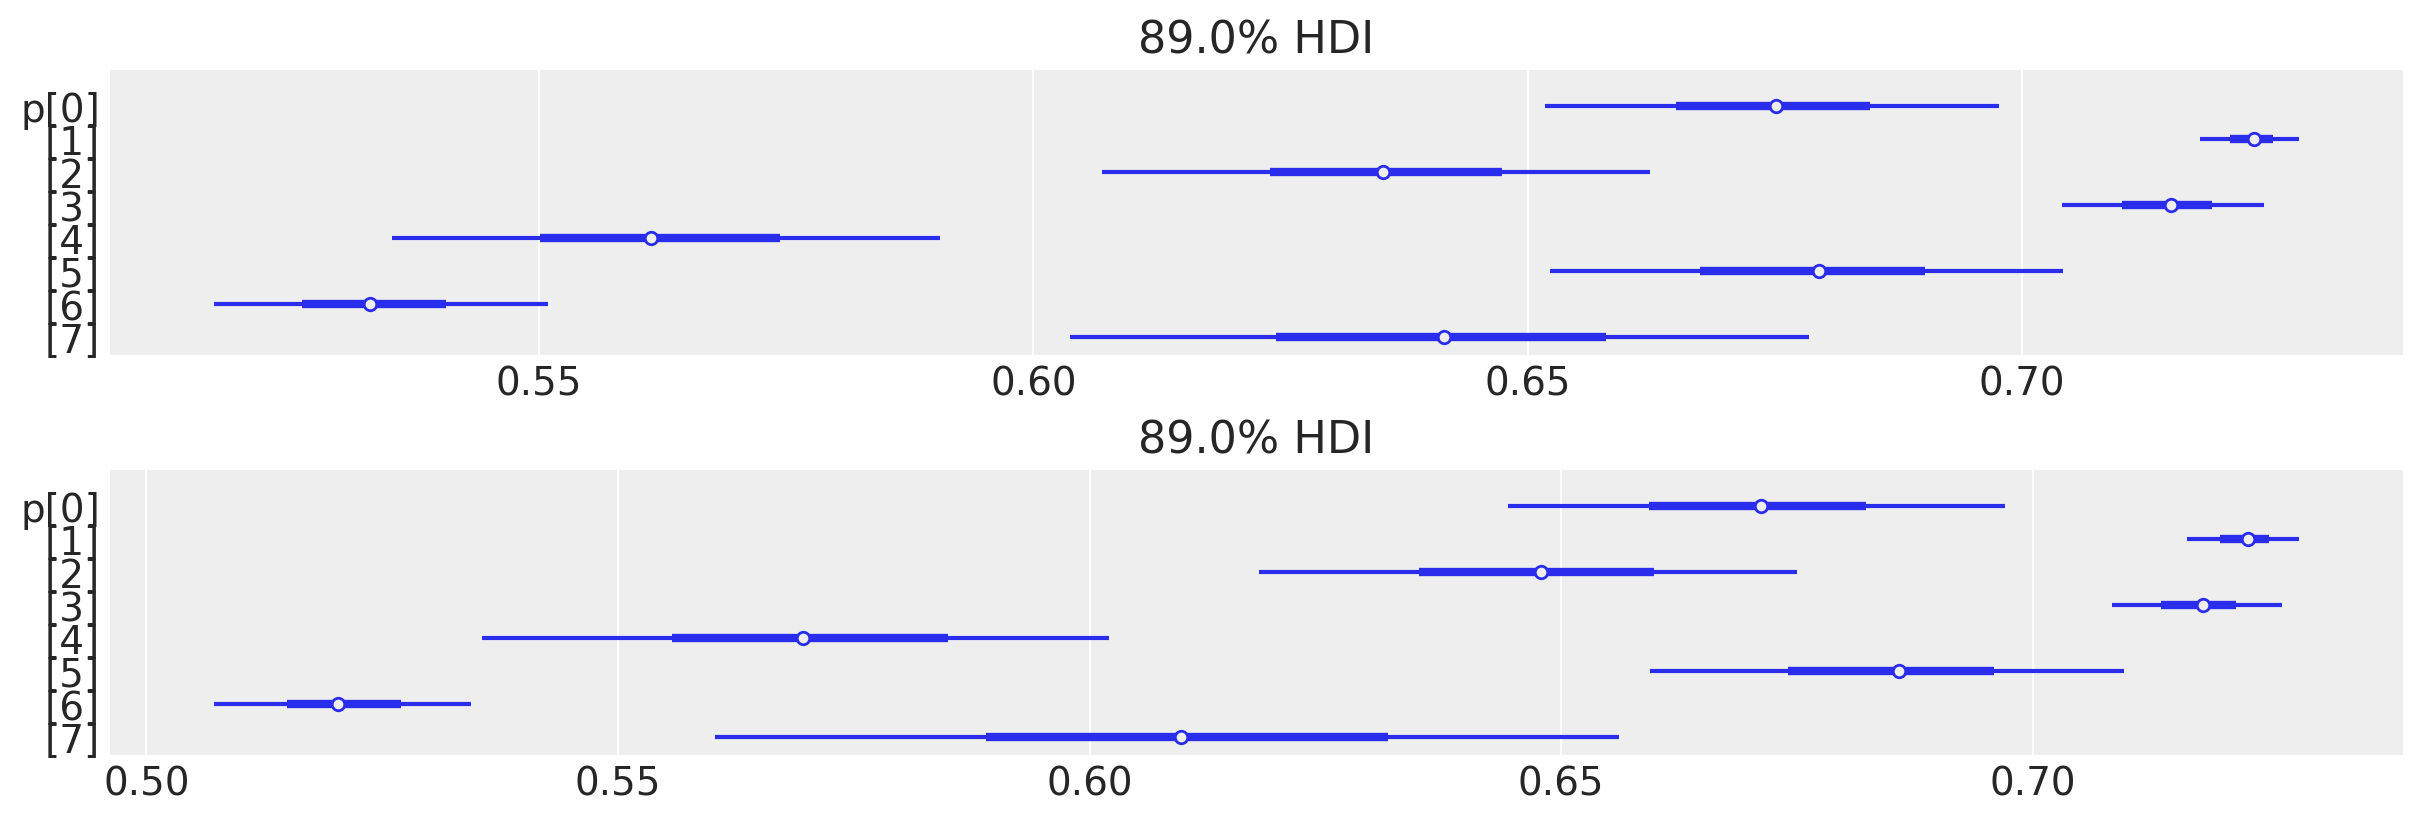

In [41]:
fig, ax = plt.subplots(2,1,figsize=(12,4))
az.plot_forest(trace_11h3a, var_names=["p"], combined=True, transform=logistic, ax=ax[0]);
az.plot_forest(trace_11h3c, var_names=["p"], combined=True, transform=logistic, ax=ax[1]);

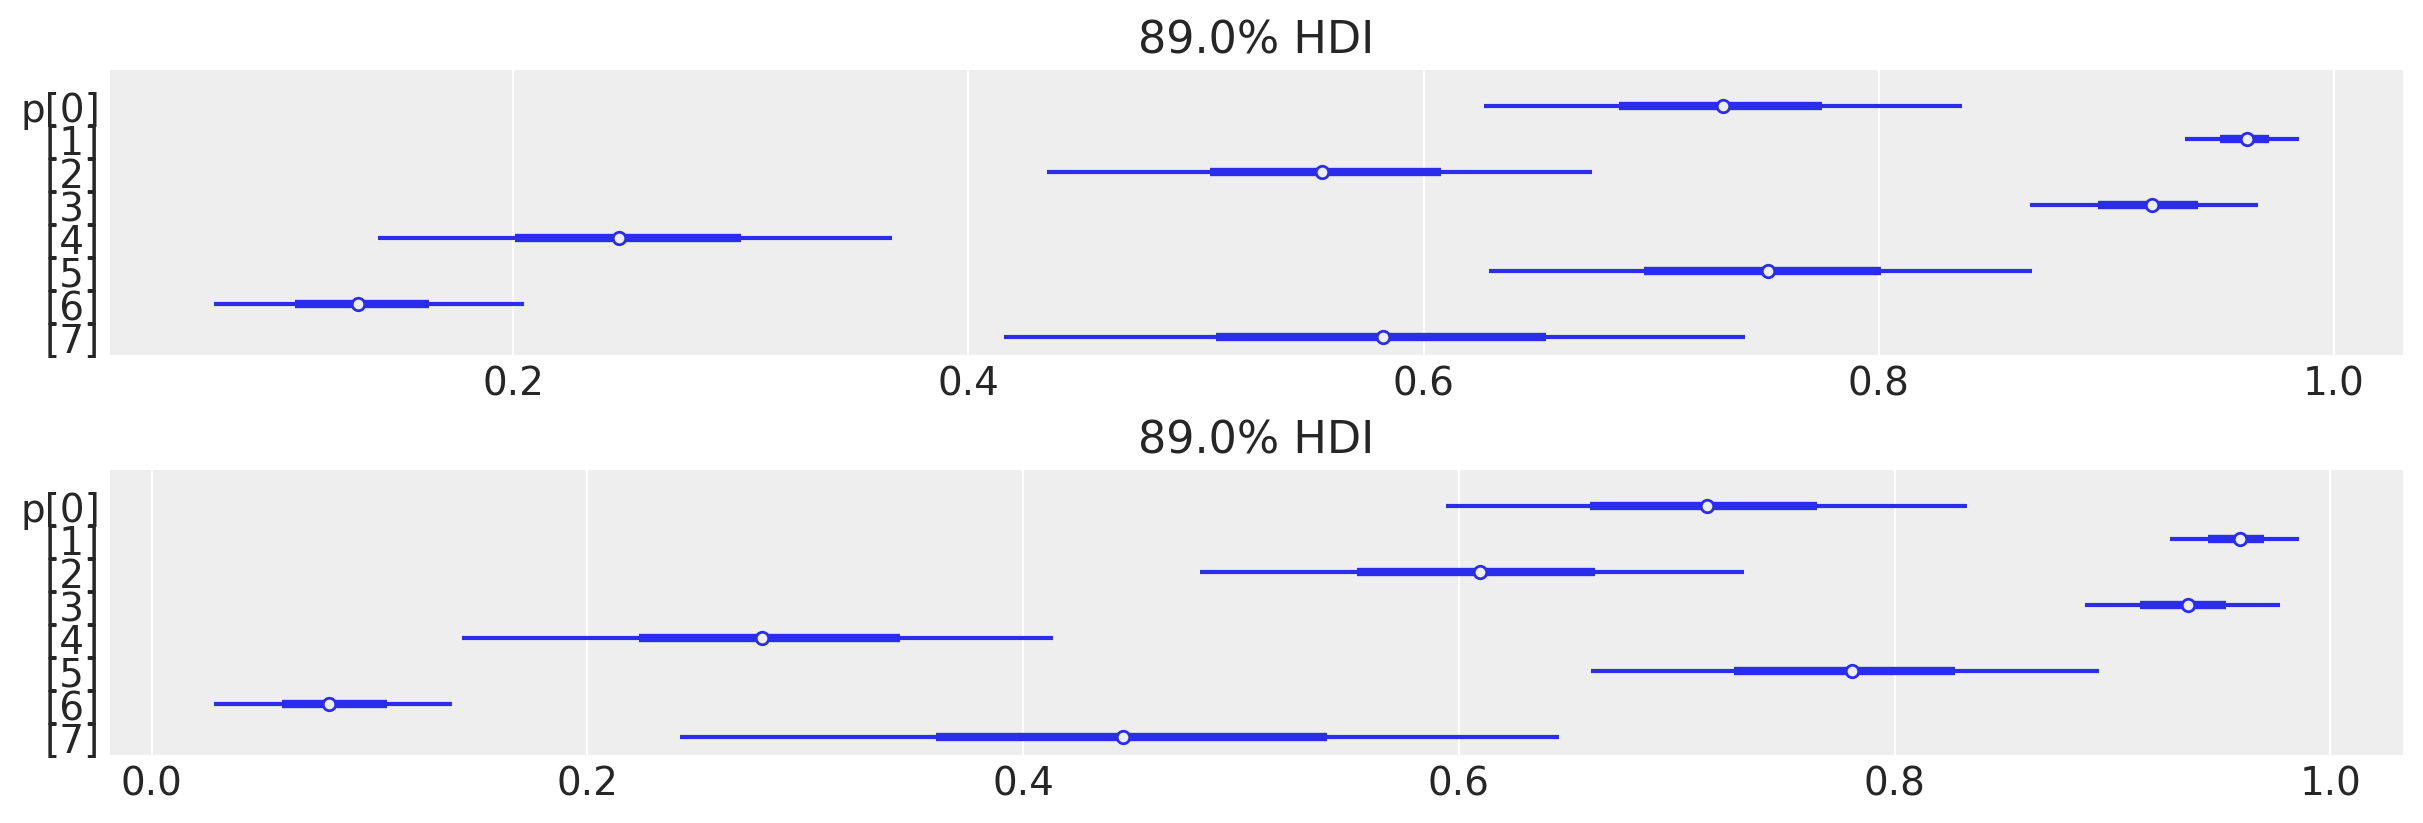

In [42]:
fig, ax = plt.subplots(2,1,figsize=(12,4))
az.plot_forest(trace_11h3a, var_names=["p"], combined=True, ax=ax[0]);
az.plot_forest(trace_11h3c, var_names=["p"], combined=True, ax=ax[1]);

In [51]:
with m11h3c:
    pp_c = pm.sample_posterior_predictive(
        trace_11h3c, random_seed=RANDOM_SEED, var_names=["stealing"])

Sampling: [stealing]


In [45]:
az.compare({"no_inter": trace_11h3a, "inter": trace_11h3c})

/work/SamueleSoraggi#7953/Repositories/bayesian_statistics/statistical_rethinking_2/pymc4/pymc4_env/lib/python3.10/site-packages/arviz/stats/stats.py:802: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/work/SamueleSoraggi#7953/Repositories/bayesian_statistics/statistical_rethinking_2/pymc4/pymc4_env/lib/python3.10/site-packages/arviz/stats/stats.py:802: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likel

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
inter,0,-21.396089,7.049165,0.00000,1.000000e+00,2.835536,0.000000,True,log
no_inter,1,-23.869129,7.398733,2.47304,4.440892e-16,3.825547,2.264768,True,log


In [46]:
# store pareto-k values for plot:
k_a = az.loo(trace_11h3a, pointwise=True).pareto_k.values

/work/SamueleSoraggi#7953/Repositories/bayesian_statistics/statistical_rethinking_2/pymc4/pymc4_env/lib/python3.10/site-packages/arviz/stats/stats.py:802: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


In [47]:
# store pareto-k values for plot:
k_c = az.loo(trace_11h3c, pointwise=True).pareto_k.values

/work/SamueleSoraggi#7953/Repositories/bayesian_statistics/statistical_rethinking_2/pymc4/pymc4_env/lib/python3.10/site-packages/arviz/stats/stats.py:802: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


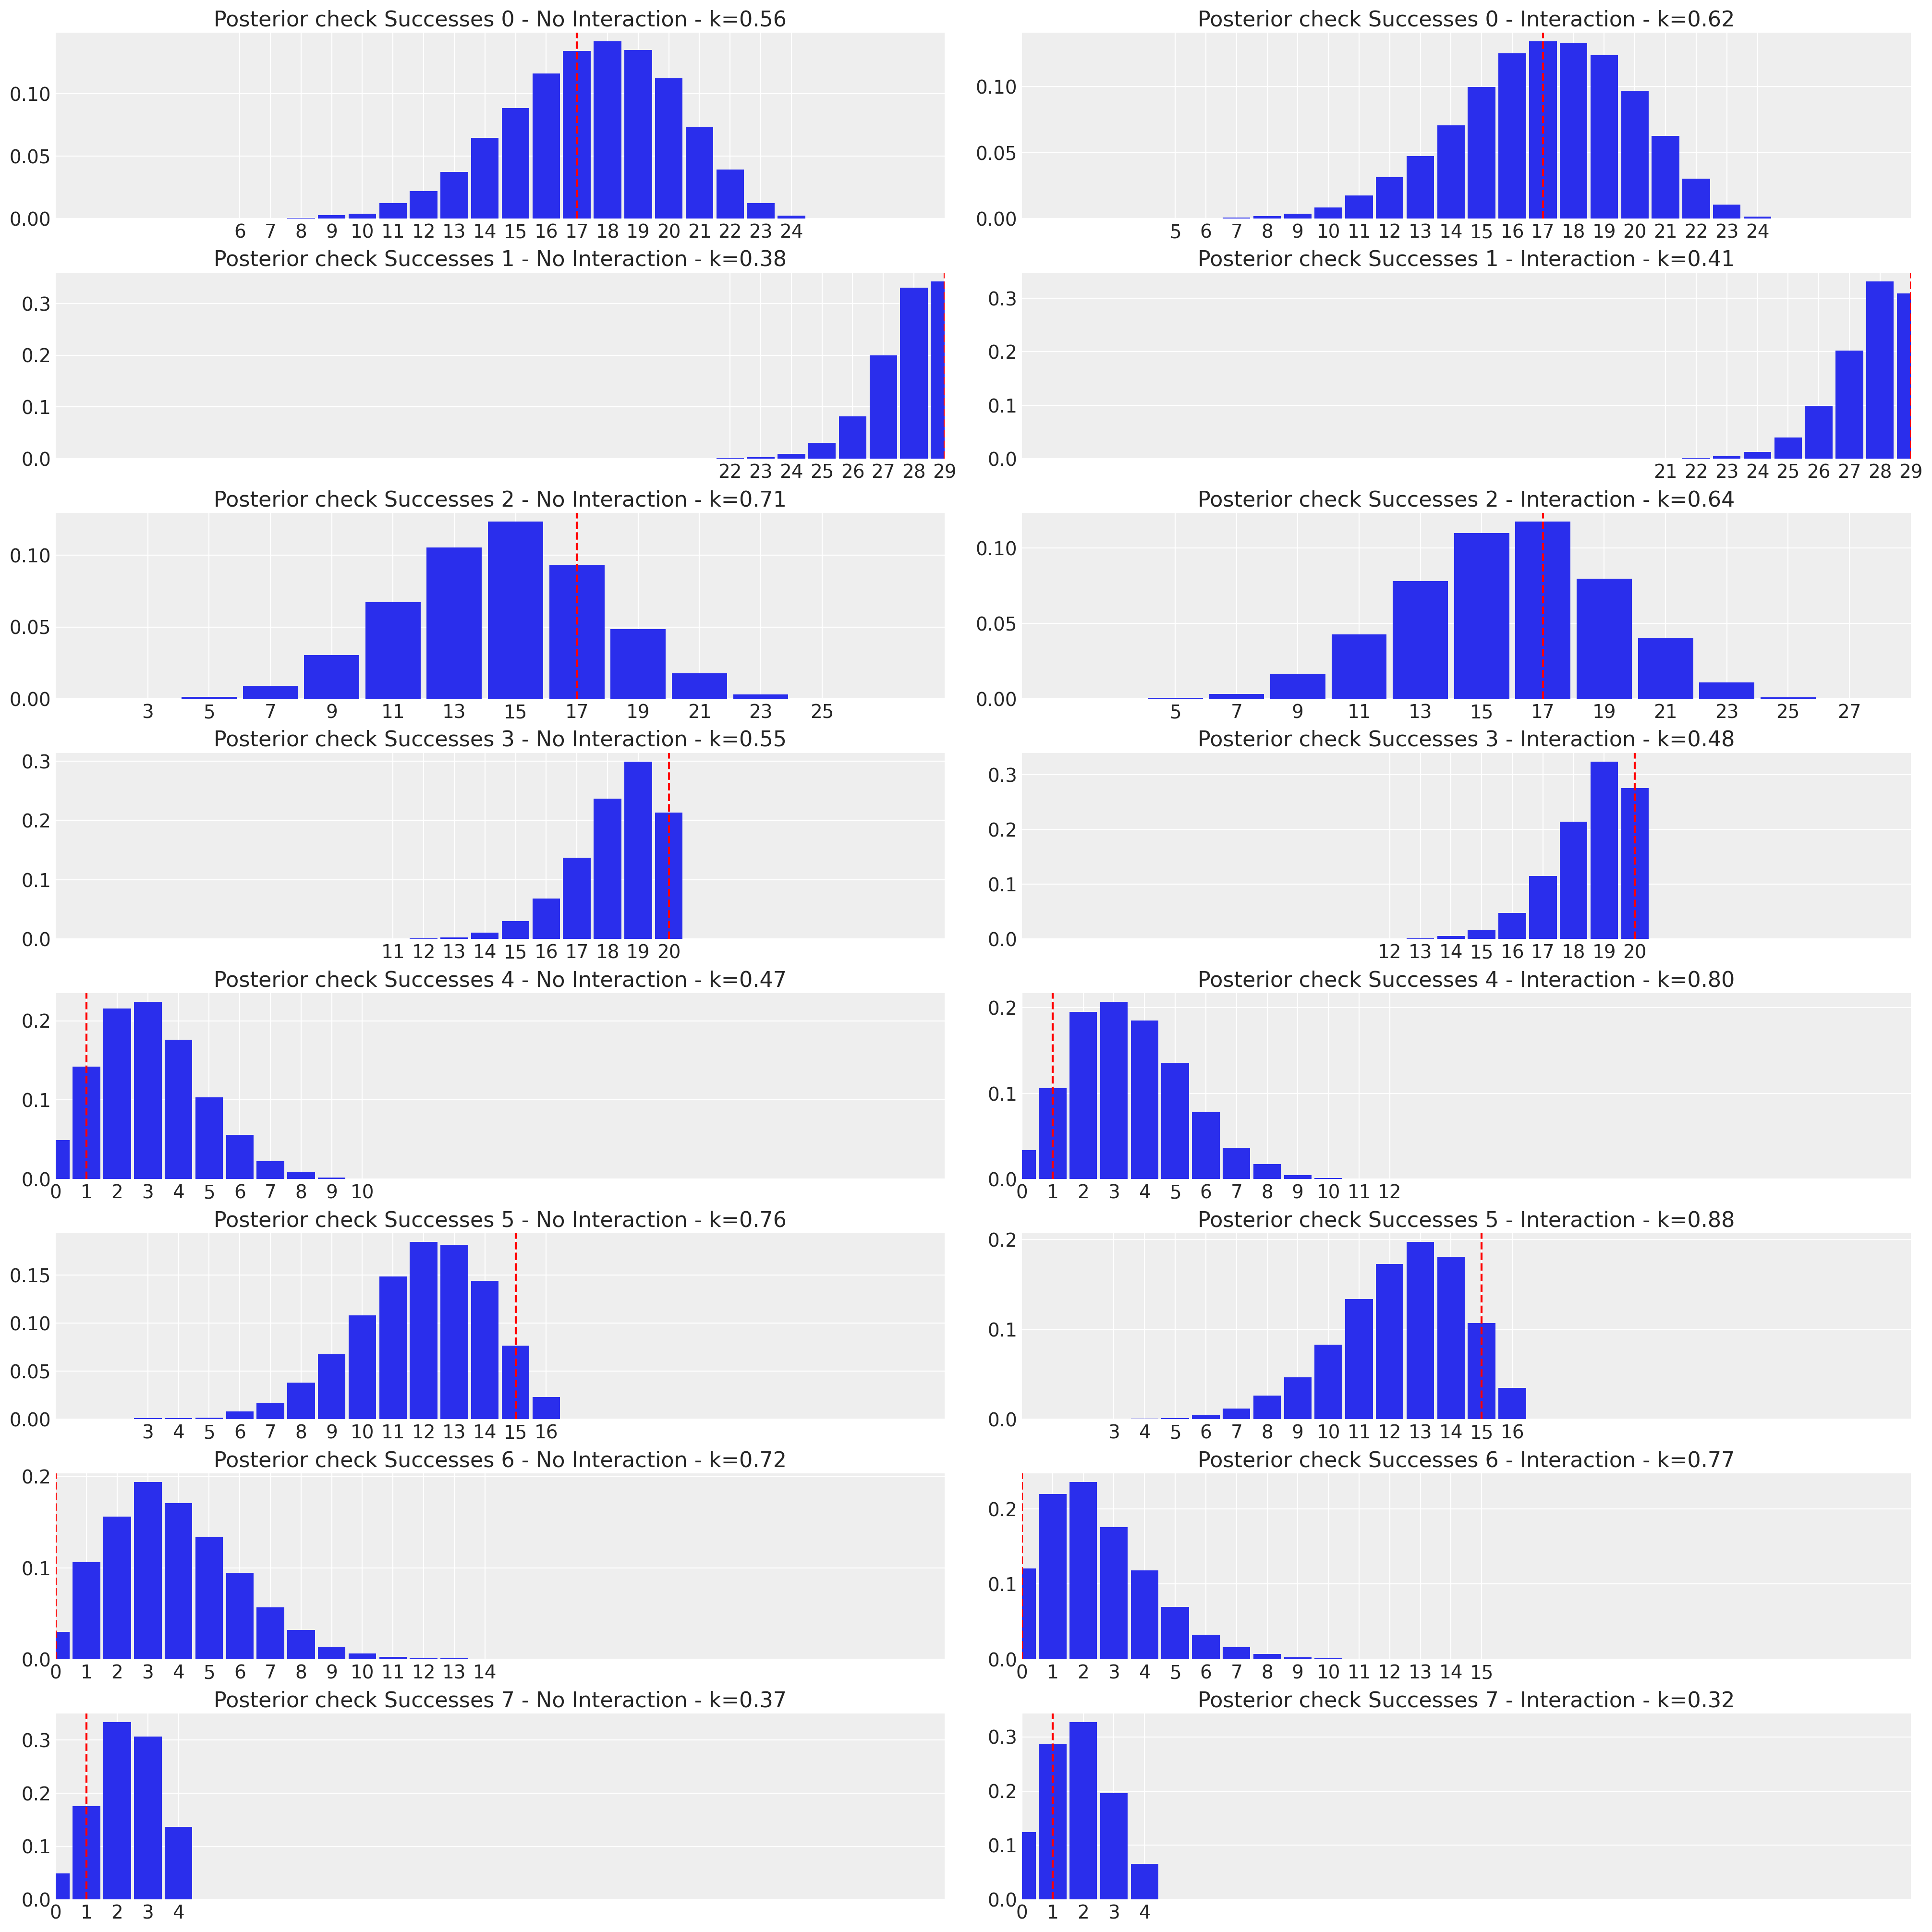

In [61]:
fig, ax = plt.subplots( 8, 2, figsize=(20,20) )
xlim=(0, np.max( (np.array(pp["posterior_predictive"]["stealing"]), np.array(pp_c["posterior_predictive"]["stealing"]))) )

for i in range(8):
    
    plot = az.plot_dist( np.array( pp["posterior_predictive"]["stealing"].sel(stealing_dim_2=i) ), ax=ax[i,0] )
    plot.axvline(x=d.y[i], c="r", ls='--', alpha=1)
    ax[i,0].set_xlim(xlim)
    ax[i,0].set_title(f"Posterior check Successes {i} - No Interaction - k={k_a[i]:.2f}", pad=5)
    
    plot = az.plot_dist( np.array( pp_c["posterior_predictive"]["stealing"].sel(stealing_dim_2=i) ), ax=ax[i,1] )
    plot.axvline(x=d.y[i], c="r", ls='--', alpha=1)
    ax[i,1].set_xlim(xlim)
    ax[i,1].set_title(f"Posterior check Successes {i} - Interaction - k={k_c[i]:.2f}", pad=5)

## Exercise 11H4

In [64]:
d = pd.read_csv("Data/salamanders.csv", sep=";")
d

,SITE,SALAMAN,PCTCOVER,FORESTAGE
0,1,13,85,316
1,2,11,86,88
2,3,11,90,548
3,4,9,88,64
4,5,8,89,43
5,6,7,83,368
6,7,6,83,200
7,8,6,91,71
8,9,5,88,42
9,10,5,90,551


In [68]:
d["logFORESTAGE"] = np.log1p(d.FORESTAGE)

<Axes: xlabel='PCTCOVER', ylabel='FORESTAGE'>

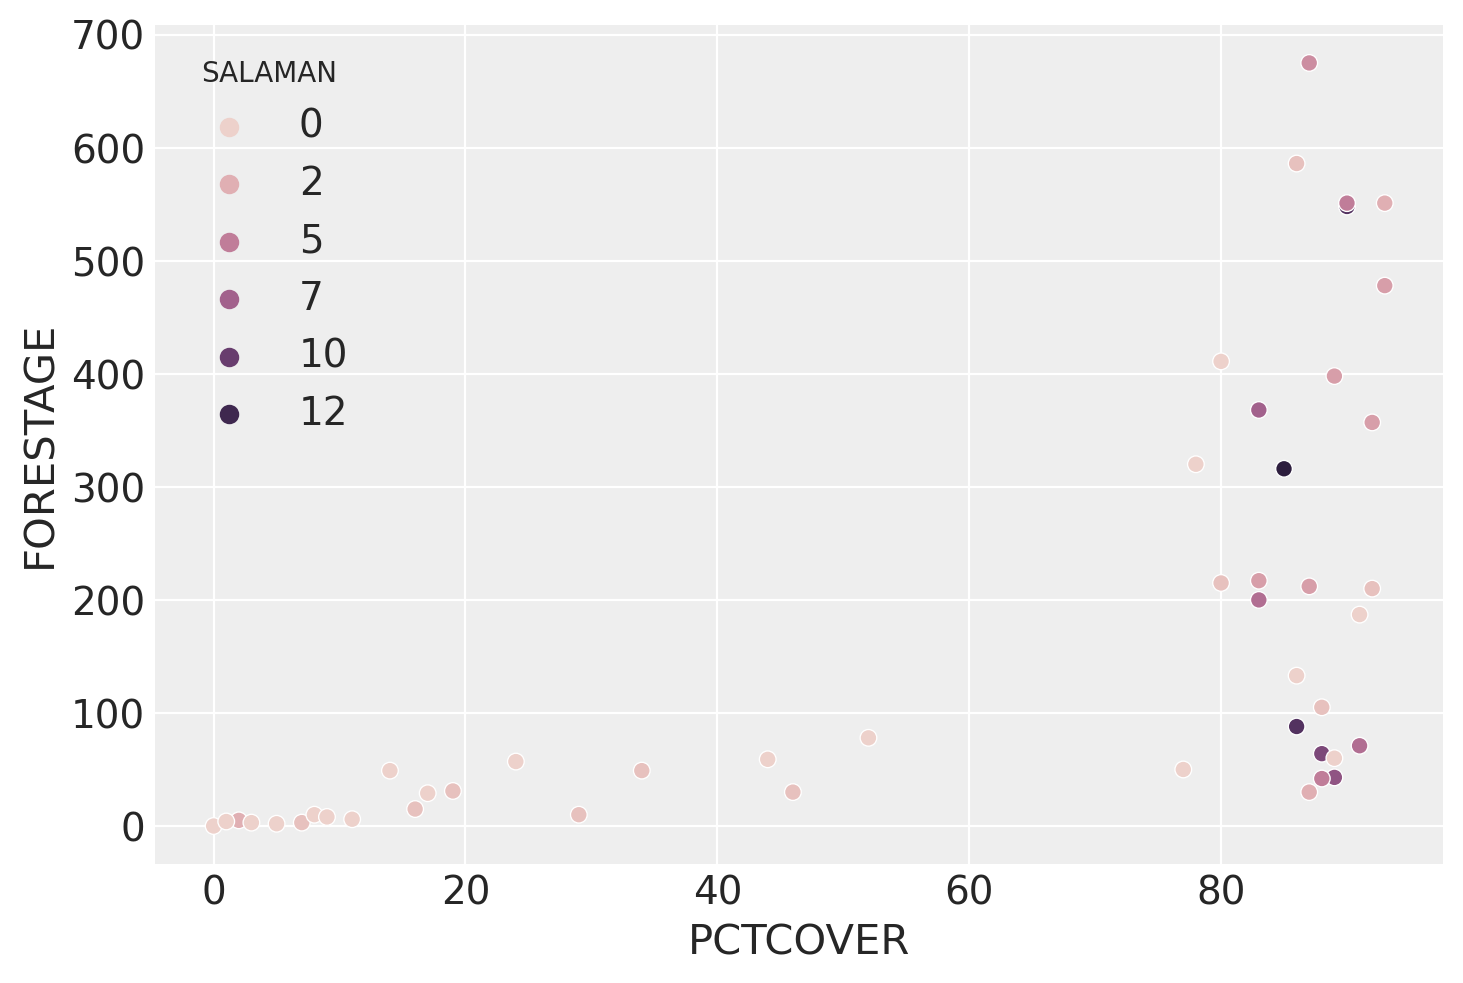

In [70]:
sns.scatterplot(data=d, x='PCTCOVER', y='FORESTAGE', hue='SALAMAN', )

<Axes: xlabel='PCTCOVER', ylabel='logFORESTAGE'>

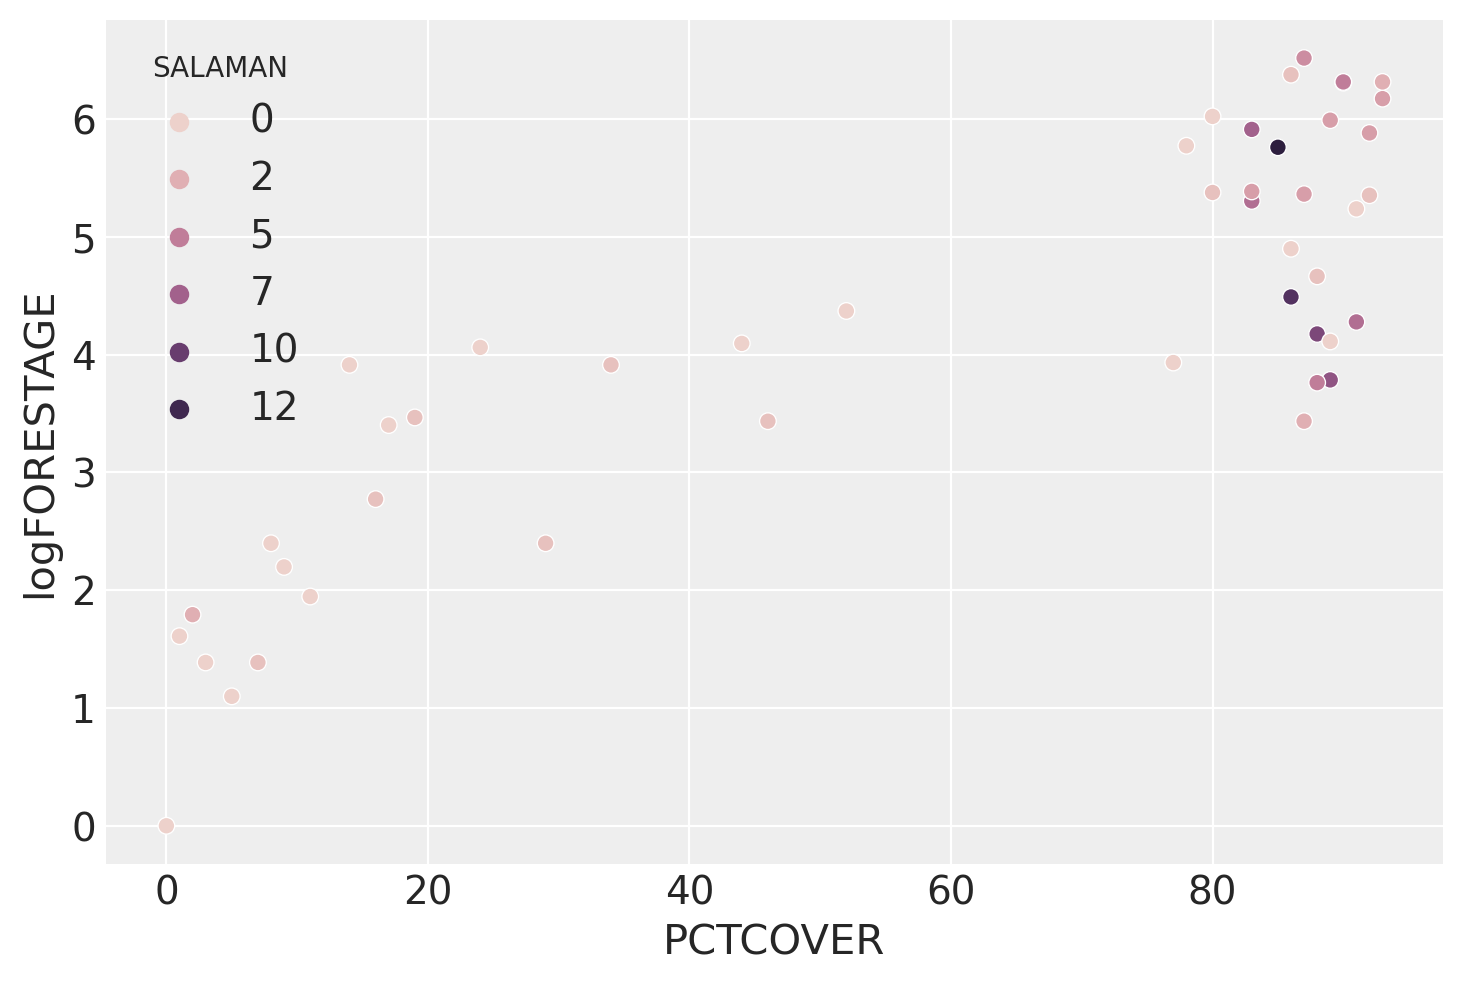

In [69]:
sns.scatterplot(data=d, x='PCTCOVER', y='logFORESTAGE', hue='SALAMAN', )

In [73]:
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

In [78]:
d["logPCTCOVER"] = np.log1p(d.PCTCOVER)

<Axes: xlabel='logPCTCOVER', ylabel='logFORESTAGE'>

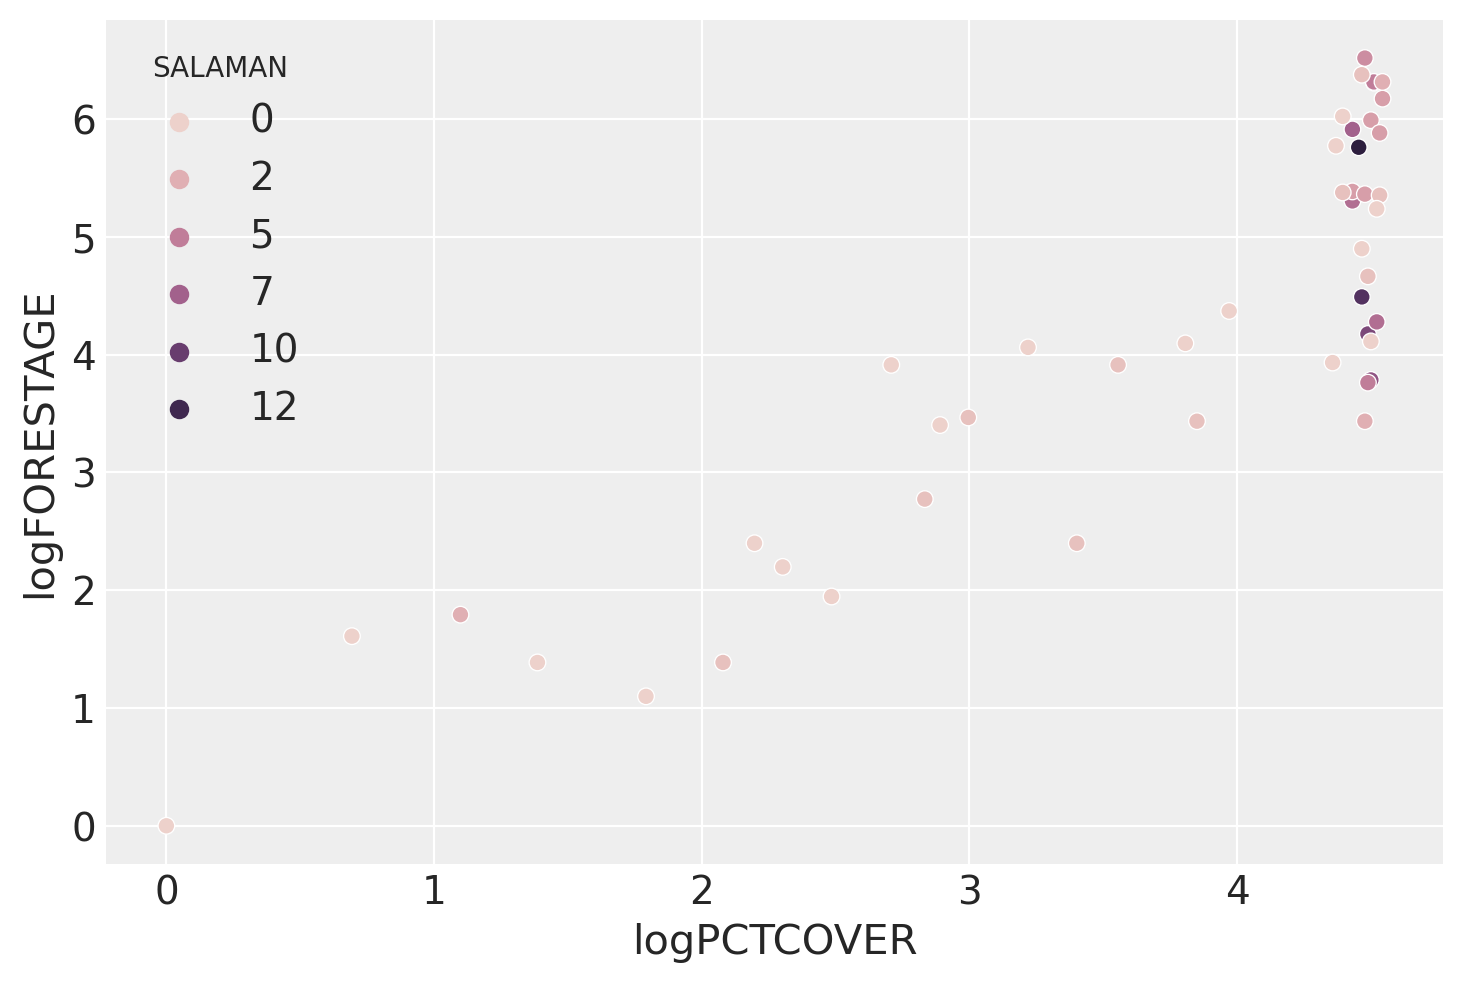

In [79]:
sns.scatterplot(data=d, x='logPCTCOVER', y='logFORESTAGE', hue='SALAMAN', )

In [62]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Tue Mar 14 2023

Python implementation: CPython
Python version       : 3.10.9
IPython version      : 8.11.0

matplotlib: 3.7.1
pandas    : 1.5.3
aesara    : 2.8.7
numpy     : 1.24.2
pymc      : 4.3.0
scipy     : 1.10.1
arviz     : 0.13.0

Watermark: 2.3.1

